In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import ipdb
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
from scipy.stats import binom, norm

from util import *

In [64]:
data = np.load('conformal_pfam.npy', allow_pickle=True)
len(data)

1864

In [3]:
data = np.load('/home/ron/protein-conformal/conformal_pfam_with_lookup_dataset.npy', allow_pickle=True)
len(data)

10000

In [ ]:
np.argmax([sum(query['exact'])/len(query['exact']) for query in data])

In [ ]:
sum(data[843]['exact'])

In [ ]:
np.median([sum(query['exact'])/len(query['exact']) for query in data])

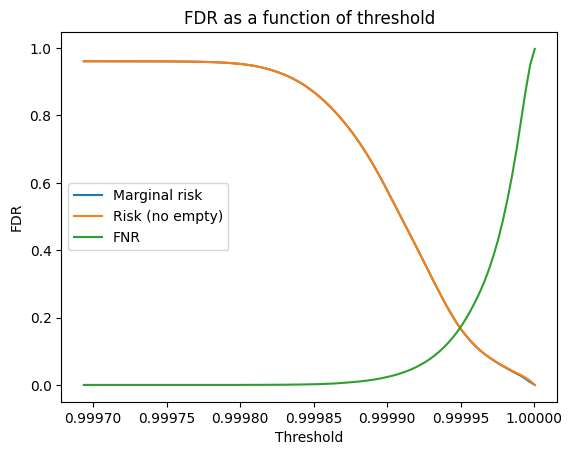

In [101]:
plt.figure()
# Plot FDR as a function of lambda
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([query['exact'] for query in data], axis=0)
sims = np.stack([query['S_i'] for query in data], axis=0)
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels, lam) for lam in lambdas]
# percentage_of_discoveries_rsk = [percentage_of_discoveries(sims, labels, lam) for lam in lambdas]
fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
plt.plot(lambdas, risks, label='Marginal risk')
plt.plot(lambdas, risks_no_empties, label='Risk (no empty)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('FDR')
plt.title('FDR as a function of threshold')
plt.legend()
plt.show()

In [63]:
alpha = 0.1
lhat = get_thresh_FDR(labels, sims, alpha, delta=0.5, N=100)

sims.max: 1.0000004768371582


/home/ron/miniconda3/envs/protein-vec/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


lhat: 0.9999663962258233
risk: 0.09136092572122927


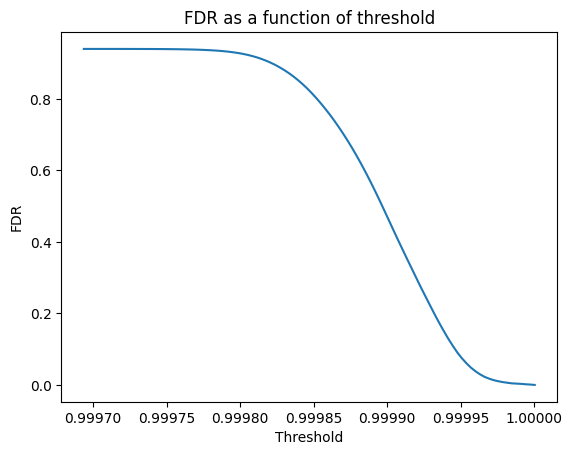

In [75]:
plt.figure()
# Plot FDR as a function of lambda
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([(np.sum(query['partial'], axis=1) >= 1) if len(np.array(query['partial']).shape) > 1 else query['partial'] for query in data], axis=0)
sims = np.stack([query['S_i'] for query in data], axis=0)
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels, lam) for lam in lambdas]
plt.plot(lambdas, risks)
plt.xlabel('Threshold')
plt.ylabel('FDR')
plt.title('FDR as a function of threshold')
plt.show()

In [ ]:
get_thresh_FDR(data, 0.5)

In [48]:
def validate_lhat(data, lhat):
    total_missed = 0
    total_missed_partial = 0
    total_exact = 0
    total_inexact_identified = 0
    total_identified = 0
    total_partial = 0
    total_partial_identified = 0
    for query in data:
        idx = query['exact']
        # if partial has multiple rows, we want to take the logical or of all of them. Otherwise just set it to the single row
        # check if there is one or more rows
        # query['partial'] = np.array(query['partial'])
        if len(np.array(query['partial']).shape) > 1:
            idx_partial = np.logical_or.reduce(query['partial'], axis=1)
        else:
            idx_partial = query['partial']
        
        sims = query['S_i']
        sims_exact = sims[idx]
        sims_partial = sims[idx_partial]
        total_missed += (sims_exact < lhat).sum()

        # TODO: are there any divisions by zero here?
        total_missed_partial += (sims_partial < lhat).sum()
        total_partial_identified += (sims_partial >= lhat).sum()
        total_partial += len(sims_partial)

        total_exact += len(sims_exact)
        total_inexact_identified += (sims[~np.array(idx)] >= lhat).sum()
        total_identified += (sims >= lhat).sum()
    return total_missed/total_exact, total_inexact_identified/total_identified, total_missed_partial/total_partial, total_partial_identified/total_identified

In [49]:
num_trials = 3
alpha = 0.1
n_calib = 5000
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:]
    lhat = get_thresh(cal_data, alpha)
    error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)
    print(f'Trial {trial+1}: Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')
    

Trial 1: Ex&!Id/Ex: 0.10, In/Id: 0.43, Pa&!Id/Pa: 0.31, Pa&Id/Id: 0.67


KeyboardInterrupt: 

In [56]:
sims, labels = get_sims_labels(test_data, partial=False)
plt.hist(np.array(sims)[np.array(labels).astype(bool)])

KeyError: 'D_i'

(array([  2069.,  12248.,  38818., 133427., 247517., 230022., 159742.,
         97177.,  23181.,   1361.]),
 array([0.99980909, 0.99982811, 0.99984714, 0.99986616, 0.99988519,
        0.99990422, 0.99992324, 0.99994227, 0.99996129, 0.99998032,
        0.99999934]),
 <BarContainer object of 10 artists>)

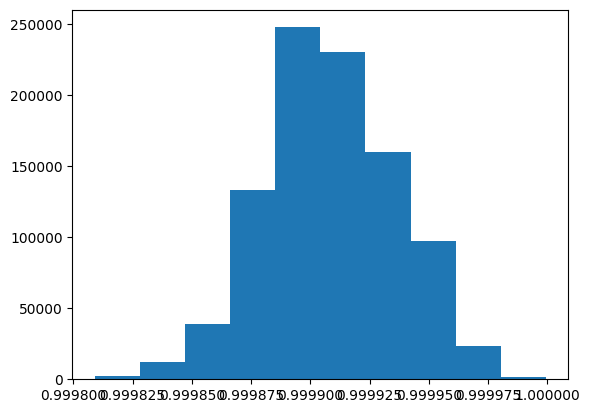

In [8]:
plt.hist(np.array(sims)[~np.array(labels).astype(bool)])

In [15]:
ir.predict(sims)

array([1.00000000e+00, 1.00000000e+00, 9.11538462e-01, ...,
       2.08751924e-04, 2.08751924e-04, 2.08751924e-04])

In [23]:
ir.predict([.5])

array([0.])

In [28]:
labels

[True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 T

In [ ]:
# Venn-Abers prediction
from util import simplifed_venn_abers_prediction

n_calib = 50
# np.random.shuffle(data)
cal_data = data[:n_calib]
test_data = data[n_calib:3*n_calib]
# ir = get_isotone_regression(cal_data)
# sims, labels = get_sims_labels(test_data, partial=False)
p_0, p_1 = simplifed_venn_abers_prediction(cal_data, test_data[0])

# preds = ir.predict(sims)
# g = sns.JointGrid()
# g.ax_joint.scatter(sims, labels, alpha=0.003)
# x = np.linspace(min(sims), max(sims), 1000)
# phats = ir.predict(x)
# g.ax_joint.plot(x, phats)
# g.ax_marg_x.hist(np.array(sims)[np.array(labels)], label='1', alpha=0.5)
# g.ax_marg_x.hist(np.array(sims)[~np.array(labels)], label='0', alpha=0.5)
# plt.show()

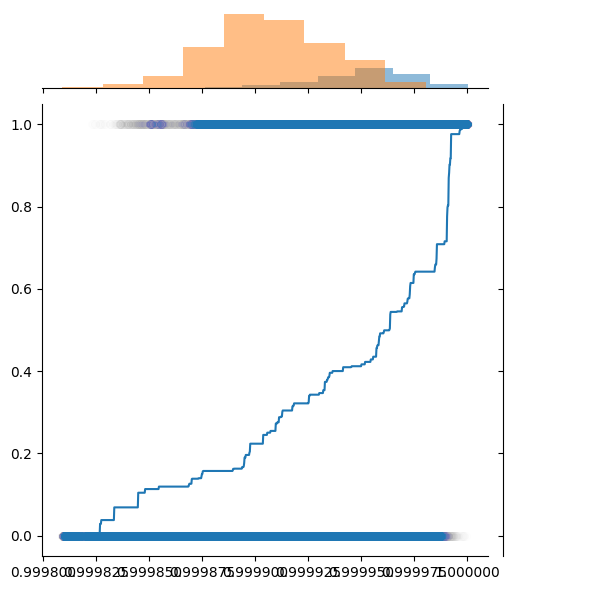

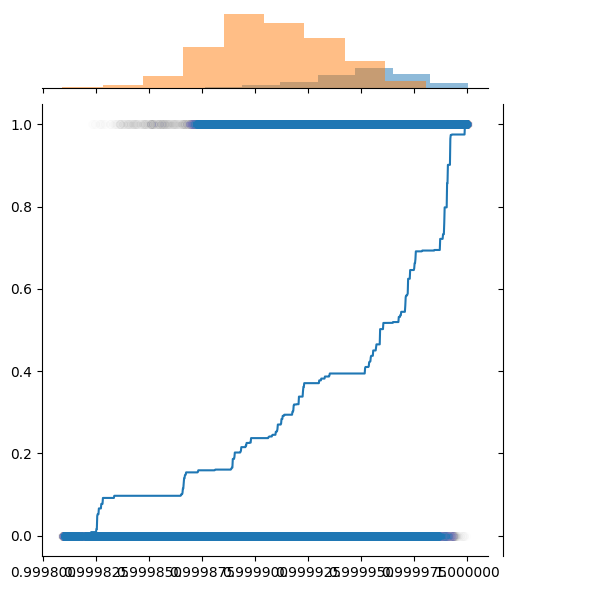

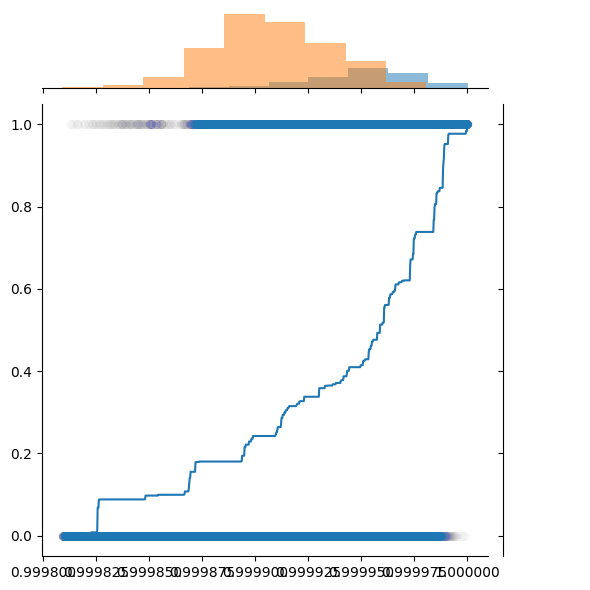

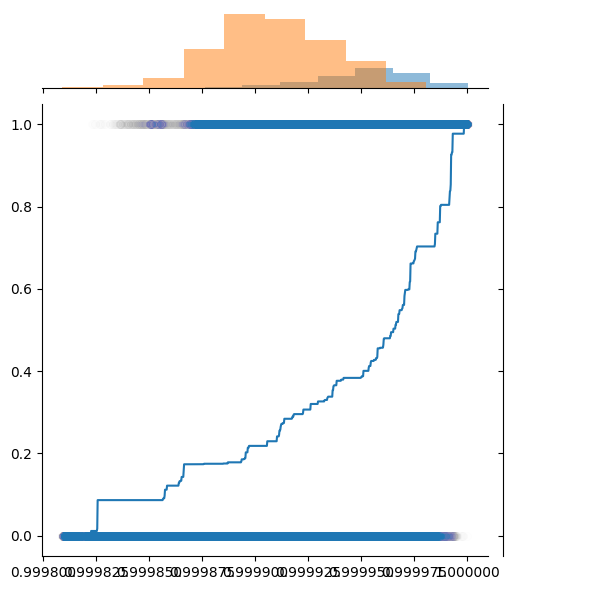

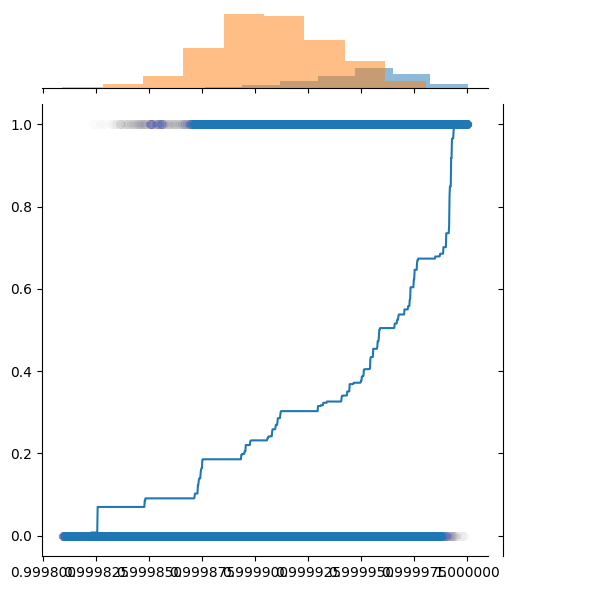

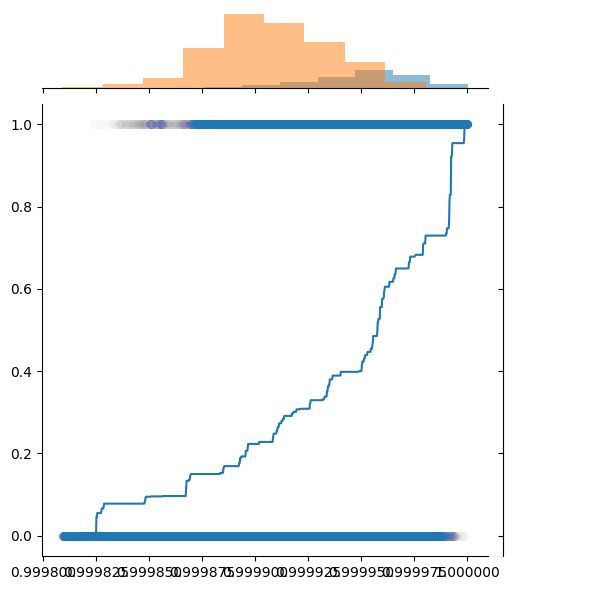

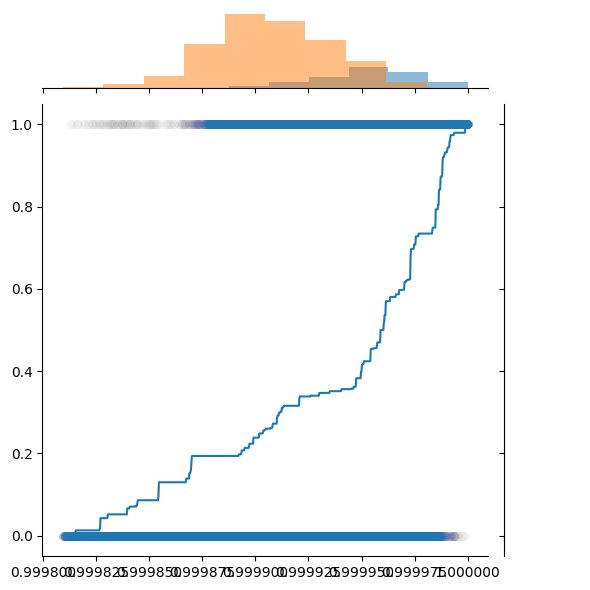

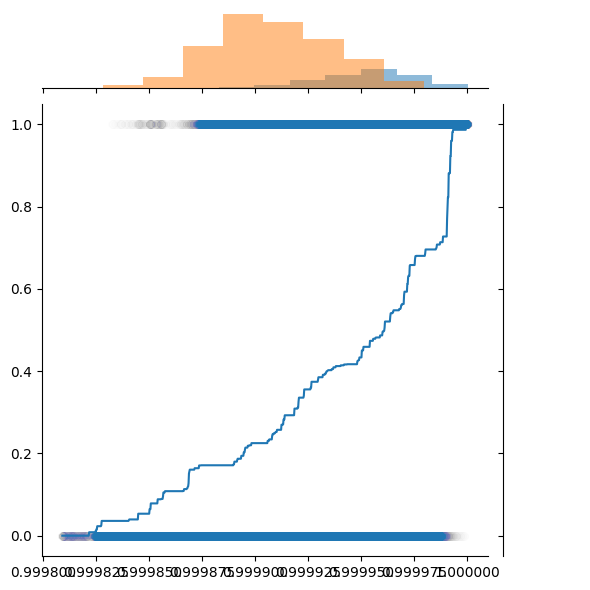

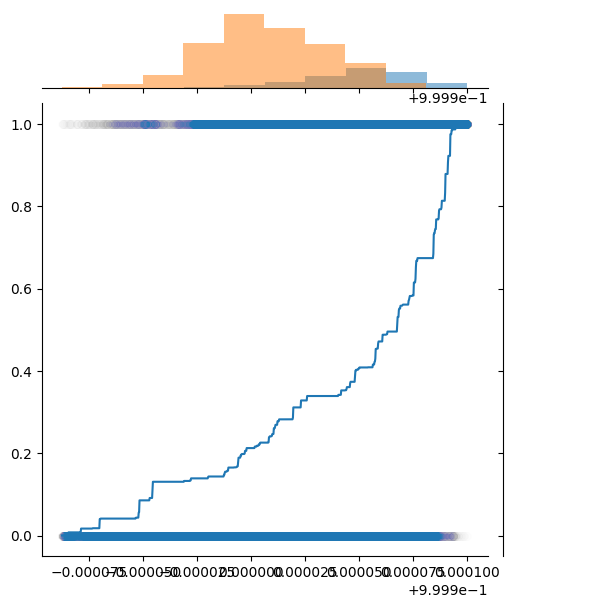

KeyboardInterrupt: 

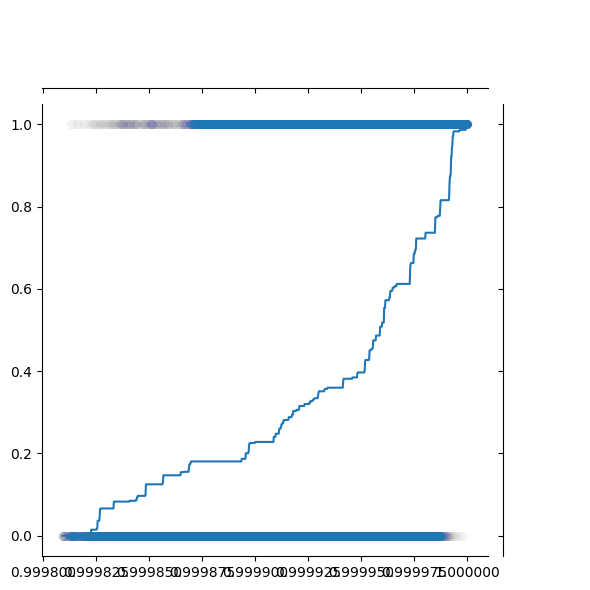

In [9]:
num_trials = 10
n_calib = 700
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:]
    ir = get_isotone_regression(cal_data)
    sims, labels = get_sims_labels(test_data, partial=False)
    preds = ir.predict(sims)
    g = sns.JointGrid()
    g.ax_joint.scatter(sims, labels, alpha=0.003)
    x = np.linspace(min(sims), max(sims), 1000)
    phats = ir.predict(x)
    g.ax_joint.plot(x, phats)
    g.ax_marg_x.hist(np.array(sims)[np.array(labels)], label='1', alpha=0.5)
    g.ax_marg_x.hist(np.array(sims)[~np.array(labels)], label='0', alpha=0.5)
    plt.show()
    ##print()
#
    #plt.figure()
    #sim_bins = np.linspace(min(sims), max(sims), 100)
    #plt.hist(np.array(sims)[np.array(labels)], bins=sim_bins, alpha=0.5, label='1')
    #plt.hist(np.array(sims)[~np.array(labels)], bins=sim_bins, alpha=0.5, label='0')
    #plt.legend()

    

In [ ]:
data[0].keys()

dict_keys(['meta', 'meta_query', 'exact', 'partial', 'D_i'])

'meta': these are the Pfam (protein family) entries from the lookup dataset. Len 1000

'meta_query': this is the Pfam of the query protein (there is only one per dict). Some proteins will have multiple pfams associated with them

'exact': True if the meta_query Pfam is in any of the Pfams for meta. Len 1000

'partial': In the case where a query protein is assigned multiple Pfams, we seek to see if we get partial hits for each of these query protein Pfams. Shape 1000 x # of Pfams for query protein

D_i: These are the similarities assigned by our model for each query to its top 1000 lookup pairs (len 1000 as well)

In [ ]:
max_sim_exact = []
for i in range(len(data[0]['exact'])):
    idx = data[0]['exact'][i]
    sims = data[0]['S_i'][i]

    max_sim = sims[idx]
    max_sim_exact.append(max(sims[idx]))

ValueError: max() arg is an empty sequence

In [ ]:
    # for lookup in query['exact']:
    #     sims = query['D_i']
    #     all_sim_exact.append(sims[lookup])

# for i in range(len(data['exact'])):
#     idx = data['exact'][i]
#     sims = data['D_i'][i]
#     sims_to_append = sims[idx]
#     # if len(sims_to_append) == 0:
#     #     sims_to_append = np.nan
#     all_sim_exact.append(sims_to_append)